# SPM 數據分析系統 - 延遲載入架構示範
# SPM Data Analysis System - Lazy Loading Architecture Demo

這個筆記本展示如何使用新的延遲載入架構來分析 SPM 數據。

## 延遲載入架構的優勢 / Advantages of Lazy Loading Architecture

1. **記憶體效率 / Memory Efficiency**: 僅載入所需要的檔案，避免不必要的記憶體使用
2. **快速啟動 / Fast Startup**: 先載入 TXT 檔案取得檔案清單，然後按需載入具體檔案
3. **彈性管理 / Flexible Management**: 可隨時載入和卸載檔案，動態管理記憶體
4. **批量操作 / Batch Operations**: 支援批量載入多個檔案，提高效率
5. **狀態監控 / Status Monitoring**: 可監控檔案載入狀態和記憶體使用情況

## 架構變更 / Architecture Changes

- `load_experiment()`: 僅載入 TXT 檔案，掃描關聯檔案但不解析
- `load_file()`: 按需載入特定檔案
- `unload_file()`: 卸載檔案釋放記憶體
- `load_multiple_files()`: 批量載入多個檔案
- `get_file_status()`: 獲取檔案載入狀態
- `get_memory_usage()`: 獲取記憶體使用情況

這個筆記本將展示這些新功能的使用方法。

# SPM 數據分析系統 - 新架構示範 / SPM Data Analysis System - New Architecture Demo

這個筆記本展示如何使用新的模組化架構來分析 SPM 數據。
This notebook demonstrates how to use the new modular architecture to analyze SPM data.

In [1]:
# 導入必要的模組 / Import necessary modules
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# 將 backend 目錄加入到 Python 路徑
# Add the backend directory to Python path
backend_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, backend_path)

print(f"Current working directory: {os.getcwd()}")
print(f"Backend path added: {backend_path}")
print(f"Core directory exists: {os.path.exists(os.path.join(backend_path, 'core'))}")
print(f"main_analyzer.py exists: {os.path.exists(os.path.join(backend_path, 'core', 'main_analyzer.py'))}")

# 導入新架構的分析器
from core.main_analyzer import MainAnalyzer

Current working directory: /Users/yangziliang/Git-Projects/keen/backend/test
Backend path added: /Users/yangziliang/Git-Projects/keen/backend
Core directory exists: True
main_analyzer.py exists: True


## 1. 初始化主分析器 / Initialize Main Analyzer

MainAnalyzer 是新架構的核心，它整合了所有的分析功能。使用 `load_experiment()` 方法載入實驗數據。

In [2]:
# 創建主分析器實例
analyzer = MainAnalyzer()

print("主分析器已初始化 / Main analyzer initialized")
print(f"可用的分析器 / Available analyzers: {list(analyzer.analyzers.keys())}")

主分析器已初始化 / Main analyzer initialized
可用的分析器 / Available analyzers: ['txt', 'int', 'dat', 'cits']


## 2. 載入測試數據 / Load Test Data

使用 testfile 資料夾中的測試數據集。使用 `load_experiment()` 方法載入整個實驗。

In [3]:
import os

# 設定測試檔案路徑
# 從當前目錄 (backend/test) 到 testfile 目錄
test_file_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'testfile', '20250521_Janus Stacking SiO2_13K_113.txt'))

# 檢查檔案是否存在
if os.path.exists(test_file_path):
    print(f"找到測試檔案 / Test file found: {os.path.basename(test_file_path)}")
    print(f"檔案路徑 / File path: {test_file_path}")
else:
    print(f"錯誤：找不到測試檔案 / Error: Test file not found")
    print(f"嘗試路徑 / Tried path: {test_file_path}")
    print(f"當前目錄 / Current directory: {os.getcwd()}")

找到測試檔案 / Test file found: 20250521_Janus Stacking SiO2_13K_113.txt
檔案路徑 / File path: /Users/yangziliang/Git-Projects/keen/testfile/20250521_Janus Stacking SiO2_13K_113.txt


In [4]:
# 使用主分析器載入實驗（延遲載入架構）
try:
    # 使用 load_experiment 方法載入實驗（僅解析 TXT 檔案）
    result = analyzer.load_experiment(test_file_path, "demo_experiment")
    
    if result['success']:
        print("實驗載入成功 / Experiment loaded successfully")
        print(f"\n實驗名稱 / Experiment name: {result['data']['experiment_name']}")
        print(f"\n可用檔案資訊 / Available files info:")
        available_files = result['data']['available_files']
        print(f"INT 檔案數量 / INT files count: {len(available_files['int_files'])}")
        print(f"DAT 檔案數量 / DAT files count: {len(available_files['dat_files'])}")
        print(f"總檔案數量 / Total files count: {available_files['total_count']}")
        print(f"已載入檔案數量 / Loaded files count: {result['data']['loaded_files_count']}")
        
        # 顯示可用的 INT 檔案
        print(f"\n可用的 INT 檔案 / Available INT files:")
        try:
            available_int_files = []
            # 首先檢查 int_files 詳細信息
            if 'int_files' in result['data'] and result['data']['int_files']:
                for file_info in result['data']['int_files']:
                    signal_type = file_info.get('signal_type', 'Unknown')
                    direction = file_info.get('direction', '')
                    direction_str = f" ({direction})" if direction else ""
                    filename = file_info.get('filename', '')
                    available_int_files.append((filename, signal_type, direction_str))
            
            # 如果沒有詳細信息，則從 available_files 獲取檔案名稱並嘗試提取訊號類型和方向
            if not available_int_files:
                # 直接從檔案名稱提取訊號類型和方向
                for filename in available_files['int_files']:
                    signal_type = "Unknown"
                    direction = ""
                    
                    # 嘗試從檔案名稱推斷訊號類型和方向
                    if "Topo" in filename:
                        signal_type = "Topo"
                    elif "Lia1R" in filename:
                        signal_type = "Lia1R"
                    elif "Lia1X" in filename:
                        signal_type = "Lia1X"
                    elif "Lia1Y" in filename:
                        signal_type = "Lia1Y"
                    elif "Lia2R" in filename:
                        signal_type = "Lia2R"
                    elif "Lia2X" in filename:
                        signal_type = "Lia2X"
                    elif "Lia2Y" in filename:
                        signal_type = "Lia2Y"
                    elif "It_to_PC" in filename:
                        signal_type = "It_to_PC"
                    
                    if "Fwd" in filename:
                        direction = " (Fwd)"
                    elif "Bwd" in filename:
                        direction = " (Bwd)"
                        
                    available_int_files.append((filename, signal_type, direction))
            
            # 顯示結果
            for filename, signal_type, direction_str in available_int_files:
                print(f"- {filename} - 訊號類型/Signal type: {signal_type}{direction_str}")
                
        except Exception as e:
            print(f"顯示 INT 檔案失敗 / Display INT files failed: {e}")
            # 使用可用檔案列表作為後備方案
            for filename in available_files['int_files']:
                print(f"- {filename}")
            
        # 顯示可用的 DAT 檔案
        print(f"\n可用的 DAT 檔案 / Available DAT files:")
        try:
            available_dat_files = []
            # 首先檢查 dat_files 詳細信息
            if 'dat_files' in result['data'] and result['data']['dat_files']:
                for file_info in result['data']['dat_files']:
                    signal_type = file_info.get('signal_type', 'Unknown')
                    filename = file_info.get('filename', '')
                    available_dat_files.append((filename, signal_type))
            
            # 如果沒有詳細信息，則從 available_files 獲取檔案名稱並嘗試提取訊號類型
            if not available_dat_files:
                # 直接從檔案名稱提取訊號類型
                for filename in available_files['dat_files']:
                    signal_type = "Unknown"
                    
                    # 嘗試從檔案名稱推斷訊號類型
                    if "Lia1R_Matrix" in filename:
                        signal_type = "Lia1R"
                    elif "Lia1Y_Matrix" in filename:
                        signal_type = "Lia1Y"
                    elif "Lia2R_Matrix" in filename:
                        signal_type = "Lia2R"
                    elif "It_to_PC_Matrix" in filename:
                        signal_type = "It_to_PC"
                        
                    available_dat_files.append((filename, signal_type))
            
            # 顯示結果
            for filename, signal_type in available_dat_files:
                print(f"- {filename} - 訊號類型/Signal type: {signal_type}")
                
        except Exception as e:
            print(f"顯示 DAT 檔案失敗 / Display DAT files failed: {e}")
            # 使用可用檔案列表作為後備方案
            for filename in available_files['dat_files']:
                print(f"- {filename}")
                
        # 顯示訊號類型摘要
        try:
            if 'signal_types' in result['data'] and result['data']['signal_types']:
                print(f"\n實驗中包含的訊號類型 / Signal types in this experiment:")
                for signal_type in result['data']['signal_types']:
                    print(f"- {signal_type}")
        except Exception as e:
            print(f"載入失敗 / Loading failed: {e}")
            # 使用可用檔案列表作為後備方案
            for filename in available_files['dat_files']:
                print(f"- {filename}")
            
        
    else:
        print(f"載入失敗 / Loading failed: {result.get('error', 'Unknown error')}")
except Exception as e:
    print(f"載入失敗 / Loading failed: {e}")

實驗載入成功 / Experiment loaded successfully

實驗名稱 / Experiment name: demo_experiment

可用檔案資訊 / Available files info:
INT 檔案數量 / INT files count: 12
DAT 檔案數量 / DAT files count: 4
總檔案數量 / Total files count: 16
已載入檔案數量 / Loaded files count: 0

可用的 INT 檔案 / Available INT files:
- 20250521_Janus Stacking SiO2_13K_113Lia1YBwd - 訊號類型/Signal type: Lia1Y (Bwd)
- 20250521_Janus Stacking SiO2_13K_113Lia1YFwd - 訊號類型/Signal type: Lia1Y (Fwd)
- 20250521_Janus Stacking SiO2_13K_113TopoBwd - 訊號類型/Signal type: Topo (Bwd)
- 20250521_Janus Stacking SiO2_13K_113TopoFwd - 訊號類型/Signal type: Topo (Fwd)
- 20250521_Janus Stacking SiO2_13K_113Lia2RBwd - 訊號類型/Signal type: Lia2R (Bwd)
- 20250521_Janus Stacking SiO2_13K_113Lia1XBwd - 訊號類型/Signal type: Lia1X (Bwd)
- 20250521_Janus Stacking SiO2_13K_113Lia1XFwd - 訊號類型/Signal type: Lia1X (Fwd)
- 20250521_Janus Stacking SiO2_13K_113Lia2RFwd - 訊號類型/Signal type: Lia2R (Fwd)
- 20250521_Janus Stacking SiO2_13K_113Lia1RBwd - 訊號類型/Signal type: Lia1R (Bwd)
- 20250521_Janus Stack

## 3. 分析 TXT 數據 / Analyze TXT Data

檢視實驗參數和元數據。

In [5]:
# 取得 TXT 分析器
txt_analyzer = analyzer.analyzers.get('txt')

# 取得當前實驗的數據
current_experiment = analyzer.get_current_experiment()

if current_experiment and txt_analyzer:
    # 顯示 TXT 數據（實驗參數）
    txt_data = current_experiment['txt_data']
    experiment_info = txt_data.get('experiment_info', {})
    
    print("實驗參數範例 / Sample experiment parameters:")
    # 只顯示前10個參數
    for i, (key, value) in enumerate(experiment_info.items()):
        if i >= 10:
            break
        print(f"  {key}: {value}")
    
    print(f"\n總共 {len(experiment_info)} 個參數 / Total {len(experiment_info)} parameters")
else:
    print("無 TXT 數據 / No TXT data available")

實驗參數範例 / Sample experiment parameters:
  Version: 1.12
  Date: 5/24/2025
  Time: 11:50:41 PM
  UserName: Supervisor
  SetPoint: 3.0E-0010
  SetPointPhysUnit: A
  FeedBackModus: STM2
  Bias: -800.000
  BiasPhysUnit: mV
  Ki: 100.000

總共 27 個參數 / Total 27 parameters


In [6]:
# 調試：檢查實驗載入狀態 / Debug: Check experiment loading status
print("=== 調試資訊 / Debug Information ===")
print(f"當前實驗名稱 / Current experiment name: {analyzer.current_experiment}")
print(f"已載入實驗數量 / Loaded experiments count: {len(analyzer.loaded_experiments)}")
print(f"已載入實驗列表 / Loaded experiments list: {list(analyzer.loaded_experiments.keys())}")

if analyzer.current_experiment:
    current_exp = analyzer.loaded_experiments.get(analyzer.current_experiment)
    if current_exp:
        print(f"當前實驗存在 / Current experiment exists: True")
        print(f"TXT 檔案路徑 / TXT file path: {current_exp['txt_file']}")
        print(f"可用檔案數量 / Available files count: {len(current_exp['available_files'])}")
        print(f"已載入檔案數量 / Loaded files count: {len(current_exp['loaded_files'])}")
    else:
        print(f"當前實驗不存在於已載入實驗中 / Current experiment not found in loaded experiments")
else:
    print(f"沒有設置當前實驗 / No current experiment set")

# 檢查是否需要重新載入實驗
if not analyzer.current_experiment:
    print("\n嘗試重新載入實驗 / Attempting to reload experiment...")
    try:
        result = analyzer.load_experiment(test_file_path, "demo_experiment")
        if result['success']:
            print("重新載入成功 / Reload successful")
        else:
            print(f"重新載入失敗 / Reload failed: {result.get('error')}")
    except Exception as e:
        print(f"重新載入異常 / Reload exception: {e}")

print("=== 調試結束 / Debug End ===")

=== 調試資訊 / Debug Information ===
當前實驗名稱 / Current experiment name: demo_experiment
已載入實驗數量 / Loaded experiments count: 1
已載入實驗列表 / Loaded experiments list: ['demo_experiment']
當前實驗存在 / Current experiment exists: True
TXT 檔案路徑 / TXT file path: /Users/yangziliang/Git-Projects/keen/testfile/20250521_Janus Stacking SiO2_13K_113.txt
可用檔案數量 / Available files count: 16
已載入檔案數量 / Loaded files count: 0
=== 調試結束 / Debug End ===


## 4. 分析 INT 數據（拓撲圖）/ Analyze INT Data (Topography)

處理和視覺化掃描探針顯微鏡的高度圖數據。

In [7]:
# 使用延遲載入來分析 INT 檔案
current_experiment = analyzer.get_current_experiment()

if current_experiment:
    # 取得可用檔案資訊
    available_files = current_experiment['available_files']
    int_files = {k: v for k, v in available_files.items() if v['type'] == 'int'}
    
    if int_files:
        print("可用的 INT 檔案 / Available INT files:")
        for file_key, file_info in int_files.items():
            size_mb = file_info['size'] / (1024 * 1024)
            loaded_status = "已載入" if file_info['loaded'] else "未載入"
            print(f"  - {file_key}")
            print(f"    大小 / Size: {size_mb:.2f} MB")
            print(f"    狀態 / Status: {loaded_status}")
        
        # 示範載入 Topo Fwd 檔案 / Demonstrate loading Topo Fwd file
        # 可以尋找signal_type 為 'Topo' 且 direction 為 'Fwd' 的檔案
        topo_fwd_file = None
        for file_key, file_info in int_files.items():
            if file_info['signal_type'] == 'Topo' and file_info['direction'] == 'Fwd':
                topo_fwd_file = file_key
                break
        print("\n示範載入 Topo Fwd 檔案 / Demonstrating loading Topo Fwd file")
        if topo_fwd_file:
            load_result = analyzer.load_file(topo_fwd_file)
            print(f"載入結果 / Load result: {load_result}")

        if load_result['success']:
            print(f"檔案載入成功 / File loaded successfully")
            print(f"檔案類型 / File type: {load_result['file_type']}")
            print(f"檔案大小 / File size: {load_result['file_size']} bytes")
            
            # 獲取影像數據
            int_data = load_result['data']
            image_data = int_data.get('image_data')
            if image_data is not None:
                print(f"影像形狀 / Image shape: {image_data.shape}")
                print(f"數值範圍 / Value range: [{np.min(image_data):.3f}, {np.max(image_data):.3f}] nm")
        else:
            print(f"檔案載入失敗 / File loading failed: {load_result.get('error')}")
    else:
        print("無可用的 INT 檔案 / No INT files available")
else:
    print("無當前實驗 / No current experiment")
    


可用的 INT 檔案 / Available INT files:
  - 20250521_Janus Stacking SiO2_13K_113Lia1YBwd
    大小 / Size: 0.95 MB
    狀態 / Status: 未載入
  - 20250521_Janus Stacking SiO2_13K_113Lia1YFwd
    大小 / Size: 0.95 MB
    狀態 / Status: 未載入
  - 20250521_Janus Stacking SiO2_13K_113TopoBwd
    大小 / Size: 0.95 MB
    狀態 / Status: 未載入
  - 20250521_Janus Stacking SiO2_13K_113TopoFwd
    大小 / Size: 0.95 MB
    狀態 / Status: 未載入
  - 20250521_Janus Stacking SiO2_13K_113Lia2RBwd
    大小 / Size: 0.95 MB
    狀態 / Status: 未載入
  - 20250521_Janus Stacking SiO2_13K_113Lia1XBwd
    大小 / Size: 0.95 MB
    狀態 / Status: 未載入
  - 20250521_Janus Stacking SiO2_13K_113Lia1XFwd
    大小 / Size: 0.95 MB
    狀態 / Status: 未載入
  - 20250521_Janus Stacking SiO2_13K_113Lia2RFwd
    大小 / Size: 0.95 MB
    狀態 / Status: 未載入
  - 20250521_Janus Stacking SiO2_13K_113Lia1RBwd
    大小 / Size: 0.95 MB
    狀態 / Status: 未載入
  - 20250521_Janus Stacking SiO2_13K_113It_to_PCFwd
    大小 / Size: 0.95 MB
    狀態 / Status: 未載入
  - 20250521_Janus Stacking SiO2_13

/var/folders/s8/x7qjkqzs44lg2tdb36y2xh680000gn/T/ipykernel_30475/713030872.py:42: UserWarning:

Glyph 25299 (\N{CJK UNIFIED IDEOGRAPH-62D3}) missing from font(s) DejaVu Sans.

/var/folders/s8/x7qjkqzs44lg2tdb36y2xh680000gn/T/ipykernel_30475/713030872.py:42: UserWarning:

Glyph 25778 (\N{CJK UNIFIED IDEOGRAPH-64B2}) missing from font(s) DejaVu Sans.

/var/folders/s8/x7qjkqzs44lg2tdb36y2xh680000gn/T/ipykernel_30475/713030872.py:42: UserWarning:

Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/keen/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 25299 (\N{CJK UNIFIED IDEOGRAPH-62D3}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/keen/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 25778 (\N{CJK UNIFIED IDEOGRAPH-64B2}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/keen/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 22294 

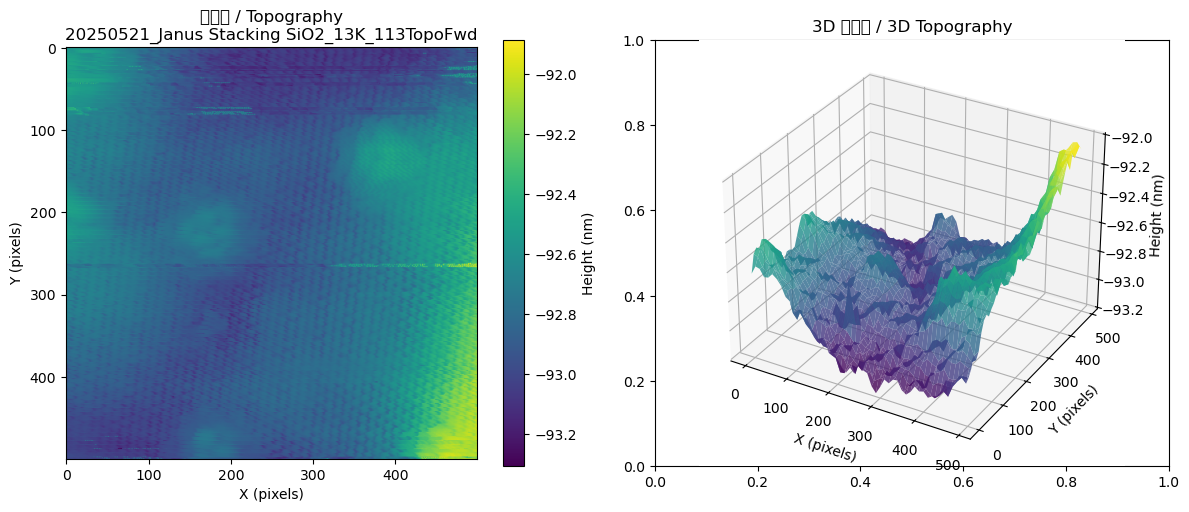


拓撲圖統計 / Topography statistics:
最小高度 / Min height: -93.305 nm
最大高度 / Max height: -91.885 nm
平均高度 / Mean height: -92.788 nm
高度標準差 / Height std: 0.197 nm
粗糙度 (RMS) / Roughness (RMS): 0.197 nm


In [8]:
# 視覺化拓撲圖（延遲載入版本）
current_experiment = analyzer.get_current_experiment()

# 載入

if current_experiment:
    # 檢查是否有已載入的 INT 檔案
    loaded_files = current_experiment['loaded_files']
    int_loaded_files = {k: v for k, v in loaded_files.items() if v['type'] == 'int'}
    
    if int_loaded_files:
        # 使用第一個已載入的 INT 檔案
        first_int_key = list(int_loaded_files.keys())[0]
        first_int_file = int_loaded_files[first_int_key]
        image_data = first_int_file['data'].get('image_data')
        
        if image_data is not None:
            # 創建圖形
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            # 原始拓撲圖
            im1 = ax1.imshow(image_data, cmap='viridis')
            ax1.set_title(f'拓撲圖 / Topography\n{first_int_key}')
            ax1.set_xlabel('X (pixels)')
            ax1.set_ylabel('Y (pixels)')
            plt.colorbar(im1, ax=ax1, label='Height (nm)')
            
            # 3D 表面圖（降採樣以提高性能）
            step = max(1, image_data.shape[0] // 50)  # 降採樣
            x = np.arange(0, image_data.shape[1], step)
            y = np.arange(0, image_data.shape[0], step)
            X, Y = np.meshgrid(x, y)
            Z = image_data[::step, ::step]
            
            ax2 = fig.add_subplot(122, projection='3d')
            surf = ax2.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
            ax2.set_title('3D 拓撲圖 / 3D Topography')
            ax2.set_xlabel('X (pixels)')
            ax2.set_ylabel('Y (pixels)')
            ax2.set_zlabel('Height (nm)')
            
            plt.tight_layout()
            plt.show()
            
            # 顯示統計資訊
            print(f"\n拓撲圖統計 / Topography statistics:")
            print(f"最小高度 / Min height: {np.min(image_data):.3f} nm")
            print(f"最大高度 / Max height: {np.max(image_data):.3f} nm")
            print(f"平均高度 / Mean height: {np.mean(image_data):.3f} nm")
            print(f"高度標準差 / Height std: {np.std(image_data):.3f} nm")
            print(f"粗糙度 (RMS) / Roughness (RMS): {np.sqrt(np.mean((image_data - np.mean(image_data))**2)):.3f} nm")
        else:
            print("無影像數據 / No image data available")
    else:
        print("無已載入的 INT 檔案 / No loaded INT files")
        print("請先載入 INT 檔案 / Please load INT files first")
else:
    print("無當前實驗 / No current experiment")

## 5. 分析 DAT 數據（CITS/STS）/ Analyze DAT Data (CITS/STS)

處理電流成像隧道光譜數據。

In [9]:
# 使用延遲載入來分析 DAT 檔案
current_experiment = analyzer.get_current_experiment()

if current_experiment:
    # 取得可用檔案資訊
    available_files = current_experiment['available_files']
    dat_files = {k: v for k, v in available_files.items() if v['type'] == 'dat'}
    
    if dat_files:
        print("可用的 DAT 檔案 / Available DAT files:")
        for file_key, file_info in dat_files.items():
            size_mb = file_info['size'] / (1024 * 1024)
            loaded_status = "已載入" if file_info['loaded'] else "未載入"
            print(f"  - {file_key}")
            print(f"    大小 / Size: {size_mb:.2f} MB")
            print(f"    狀態 / Status: {loaded_status}")
        
        # 示範載入第一個 DAT 檔案
        first_dat_key = list(dat_files.keys())[0]
        print(f"\n載入第一個 DAT 檔案 / Loading first DAT file: {first_dat_key}")
        
        load_result = analyzer.load_file(first_dat_key)
        if load_result['success']:
            print(f"檔案載入成功 / File loaded successfully")
            print(f"檔案類型 / File type: {load_result['file_type']}")
            print(f"檔案大小 / File size: {load_result['file_size']} bytes")
            
            # 獲取 CITS 數據
            dat_data = load_result['data']
            cits_data = dat_data.get('cits_data')
            if cits_data is not None:
                print(f"CITS 數據形狀 / CITS data shape: {cits_data.shape}")
                print(f"維度說明 / Dimensions: (y_pixels, x_pixels, bias_points)")
                print(f"測量模式 / Measurement mode: {dat_data.get('measurement_mode', 'Unknown')}")
                print(f"數據類型 / Data type: {dat_data.get('data_type', 'Unknown')}")
        else:
            print(f"檔案載入失敗 / File loading failed: {load_result.get('error')}")
    else:
        print("無可用的 DAT 檔案 / No DAT files available")
else:
    print("無當前實驗 / No current experiment")

可用的 DAT 檔案 / Available DAT files:
  - 20250521_Janus Stacking SiO2_13K_113Lia2R_Matrix
    大小 / Size: 46.14 MB
    狀態 / Status: 未載入
  - 20250521_Janus Stacking SiO2_13K_113Lia1R_Matrix
    大小 / Size: 46.14 MB
    狀態 / Status: 未載入
  - 20250521_Janus Stacking SiO2_13K_113Lia1Y_Matrix
    大小 / Size: 46.81 MB
    狀態 / Status: 未載入
  - 20250521_Janus Stacking SiO2_13K_113It_to_PC_Matrix
    大小 / Size: 48.92 MB
    狀態 / Status: 未載入

載入第一個 DAT 檔案 / Loading first DAT file: 20250521_Janus Stacking SiO2_13K_113Lia2R_Matrix
檔案載入成功 / File loaded successfully
檔案類型 / File type: dat
檔案大小 / File size: 48377926 bytes


/Users/yangziliang/Git-Projects/keen/backend/core/parsers/dat_parser.py:72: DtypeWarning:

Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.



In [10]:
# 從 CITS 數據中提取單點 I-V 曲線（延遲載入版本）
current_experiment = analyzer.get_current_experiment()

if current_experiment:
    # 檢查是否有已載入的 DAT 檔案
    loaded_files = current_experiment['loaded_files']
    dat_loaded_files = {k: v for k, v in loaded_files.items() if v['type'] == 'dat'}
    print(f"已載入的 DAT 檔案數量 / Number of loaded DAT files: {len(dat_loaded_files)}")
    
    if dat_loaded_files:
        # 使用第一個已載入的 DAT 檔案
        first_dat_key = list(dat_loaded_files.keys())[0]
        first_dat_file = dat_loaded_files[first_dat_key]
        dat_data = first_dat_file['data']
        
        # 先來印一些dat_data基本資訊
        print(f"檔案載入成功 / File loaded successfully")
        print(f"測量模式 / Measurement mode: {dat_data.get('measurement_mode', 'Unknown')}")
        print(f"數據類型 / Data type: {dat_data.get('data_type', 'Unknown')}")
        print(f"數據形狀 / Data shape: {dat_data.get('data_3d', np.array([])).shape}")
        print(f"偏壓點數 / Number of bias points: {len(dat_data.get('bias_values', []))}")
        print(f"網格大小 / Grid size: {dat_data.get('grid_size', 'Unknown')}")
        print(f"偏壓單位 / Bias units: {dat_data.get('units', {}).get('bias', 'Unknown')}")
        
        
        
        # 修正：檢查是否為 CITS 數據並正確存取
        if dat_data.get('measurement_mode') == 'CITS' and 'data_3d' in dat_data:
            print(f"測量模式 / Measurement mode: {dat_data.get('measurement_mode', 'Unknown')}")
            print(f"數據類型 / Data type: {dat_data.get('data_type', 'Unknown')}")
            
            # 獲取CITS 3D數據陣列 (n_bias, y, x)
            cits_data_3d = dat_data['data_3d']
            bias_values = dat_data.get('bias_values', [])
            grid_size = dat_data.get('grid_size', [cits_data_3d.shape[2], cits_data_3d.shape[1]])
            
            print(f"CITS 數據形狀 / CITS data shape: {cits_data_3d.shape}")
            print(f"網格大小 / Grid size: {grid_size}")
            print(f"偏壓點數 / Number of bias points: {len(bias_values)}")
            
            # 選擇圖像中心點
            y_center = cits_data_3d.shape[1] // 2
            x_center = cits_data_3d.shape[2] // 2
            
            # 提取該點的 I-V 曲線 (所有偏壓點在該位置的電流值)
            iv_curve = cits_data_3d[:, y_center, x_center]
            
            # 使用偏壓值，如果沒有則創建預設值
            if len(bias_values) == len(iv_curve):
                bias_points = np.array(bias_values)
                # 如果偏壓單位是mV，轉換為V
                if dat_data.get('units', {}).get('bias') == 'mV':
                    bias_points = bias_points / 1000.0
                    print("偏壓單位已從 mV 轉換為 V / Bias units converted from mV to V")
            else:
                # 使用預設偏壓範圍（-1V 到 +1V）
                bias_points = np.linspace(-1, 1, len(iv_curve))
                print("使用預設偏壓範圍 / Using default bias range")
            
            print(f"偏壓範圍 / Bias range: {bias_points.min():.3f}V 到 {bias_points.max():.3f}V")
            
            # 繪製 I-V 曲線
            plt.figure(figsize=(10, 6))
            
            # 原始 I-V 曲線
            plt.subplot(1, 2, 1)
            plt.plot(bias_points, iv_curve, 'b-', linewidth=2)
            plt.xlabel('Bias Voltage (V)')
            plt.ylabel('Current (A)')
            plt.title(f'I-V Curve at Center Point ({x_center}, {y_center})\nFile: {first_dat_key}')
            plt.grid(True, alpha=0.3)
            
            # 結導性 (dI/dV) 曲線
            plt.subplot(1, 2, 2)
            # 計算數值微分來獲得 dI/dV
            if len(bias_points) > 1:
                didv = np.gradient(iv_curve, bias_points)
                plt.plot(bias_points, didv, 'r-', linewidth=2)
                plt.xlabel('Bias Voltage (V)')
                plt.ylabel('dI/dV (S)')
                plt.title('Conductance (dI/dV)')
                plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # 顯示統計資訊
            print(f"\nI-V 曲線統計 / I-V curve statistics:")
            print(f"最小電流 / Min current: {np.min(iv_curve):.3f} nA")
            print(f"最大電流 / Max current: {np.max(iv_curve):.3f} nA")
            print(f"平均電流 / Mean current: {np.mean(iv_curve):.3f} nA")
            print(f"電流標準差 / Current std: {np.std(iv_curve):.3f} nA")
        else:
            print("無法找到 CITS 數據 / No CITS data found")
    else:
        print("無已載入的 DAT 檔案 / No loaded DAT files")
        print("請先載入 DAT 檔案 / Please load DAT files first")
else:
    print("無當前實驗 / No current experiment")

已載入的 DAT 檔案數量 / Number of loaded DAT files: 1
檔案載入成功 / File loaded successfully
測量模式 / Measurement mode: STS
數據類型 / Data type: Unknown
數據形狀 / Data shape: (0,)
偏壓點數 / Number of bias points: 401
網格大小 / Grid size: Unknown
偏壓單位 / Bias units: mV
無法找到 CITS 數據 / No CITS data found


## 6. 整合分析示範 / Integrated Analysis Demo

展示如何結合不同的分析器進行綜合分析。

In [ ]:
# 這裡可以加入更多整合分析的範例
# 例如：
# - 在拓撲圖上選擇區域進行 CITS 分析
# - 提取線輪廓並進行統計分析
# - 生成 Plotly 互動式圖表

# 整合分析示範 / Integrated Analysis Demo
# 展示延遲載入架構的優勢和機能

# 1. 獲取當前實驗的摘要
experiment_summary = analyzer.get_experiment_summary()

if experiment_summary['success']:
    print("實驗摘要 / Experiment Summary:")
    summary_data = experiment_summary['data']
    print(f"實驗名稱 / Experiment name: {summary_data['experiment_name']}")
    
    # 顯示檔案統計
    files_summary = summary_data['files_summary']
    print(f"\n檔案統計 / File Statistics:")
    print(f"可用檔案 / Available files:")
    print(f"  - INT 檔案: {files_summary['available_files']['int_files']}")
    print(f"  - DAT 檔案: {files_summary['available_files']['dat_files']}")
    print(f"  - 總計: {files_summary['available_files']['total_files']}")
    
    print(f"已載入檔案 / Loaded files:")
    print(f"  - INT 檔案: {files_summary['loaded_files']['int_files']}")
    print(f"  - DAT 檔案: {files_summary['loaded_files']['dat_files']}")
    print(f"  - CITS 檔案: {files_summary['loaded_files']['cits_files']}")
    print(f"  - 總計: {files_summary['loaded_files']['total_loaded']}")
    
    # 顯示記憶體使用情況
    memory_usage = summary_data['memory_usage']
    total_size_mb = memory_usage['available_files_size'] / (1024 * 1024)
    print(f"\n記憶體使用 / Memory Usage:")
    print(f"可用檔案總大小 / Total available files size: {total_size_mb:.2f} MB")
    print(f"已載入檔案數量 / Loaded files count: {memory_usage['loaded_files_count']}")
    
    print("\n" + "="*50)
    
# 2. 獲取檔案載入狀態
file_status = analyzer.get_file_status()
if file_status['success']:
    status_data = file_status['data']
    summary = status_data['summary']
    
    print("檔案載入狀態 / File Loading Status:")
    print(f"總檔案數 / Total files: {summary['total_files']}")
    print(f"已載入數 / Loaded files: {summary['loaded_files']}")
    print(f"載入百分比 / Loading percentage: {summary['loading_percentage']:.1f}%")
    
    total_size_mb = summary['total_size_bytes'] / (1024 * 1024)
    loaded_size_mb = summary['loaded_size_bytes'] / (1024 * 1024)
    print(f"總檔案大小 / Total file size: {total_size_mb:.2f} MB")
    print(f"已載入大小 / Loaded file size: {loaded_size_mb:.2f} MB")
    
    print("\n" + "="*50)

# 3. 示範批量載入功能
current_experiment = analyzer.get_current_experiment()
if current_experiment:
    available_files = current_experiment['available_files']
    unloaded_files = [k for k, v in available_files.items() if not v['loaded']]
    
    if unloaded_files and len(unloaded_files) > 0:
        # 選擇前兩個未載入的檔案進行批量載入示範
        files_to_load = unloaded_files[:2]
        print(f"批量載入示範 / Batch loading demo:")
        print(f"將載入 {len(files_to_load)} 個檔案: {files_to_load}")
        
        batch_result = analyzer.load_multiple_files(files_to_load)
        if batch_result['success']:
            batch_summary = batch_result['data']['summary']
            print(f"批量載入結果 / Batch loading result:")
            print(f"成功: {batch_summary['success_count']}, 失敗: {batch_summary['fail_count']}")
            print(f"成功率: {batch_summary['success_rate']:.1f}%")
        
        print("\n" + "="*50)
    
    # 4. 獲取更新後的記憶體使用情況
    memory_info = analyzer.get_memory_usage()
    if memory_info['success']:
        mem_data = memory_info['data']
        print("記憶體使用情況 / Memory Usage Information:")
        print(f"總可用檔案: {mem_data['file_counts']['total_available']}")
        print(f"當前已載入: {mem_data['file_counts']['currently_loaded']}")
        print(f"記憶體效率: {mem_data['size_info']['memory_efficiency']:.1f}%")
        print(f"人類可讀格式:")
        print(f"  - 總大小: {mem_data['human_readable']['total_available']}")
        print(f"  - 已載入: {mem_data['human_readable']['currently_loaded']}")

print("\n\n延遲載入架構示範完成 / Lazy loading architecture demo completed!")
print("優勢 / Advantages:")
print("1. 節省記憶體 - 僅載入所需檔案 / Memory efficient - load only needed files")
print("2. 快速啟動 - 先載入 TXT 檔案取得檔案清單 / Fast startup - load TXT first to get file list")
print("3. 彈性管理 - 可以隨時載入和卸載檔案 / Flexible management - load/unload files on demand")
print("4. 批量操作 - 支援批量載入多個檔案 / Batch operations - support batch loading")